In [1]:
import tessreduce as tr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PRF import TESS_PRF
from copy import deepcopy
from photutils.detection import StarFinder
from astropy.stats import sigma_clipped_stats
from scipy.ndimage import center_of_mass
import multiprocessing
from joblib import Parallel, delayed 
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=RuntimeWarning) 
%matplotlib widget

import sep

In [146]:
# -- Primary Detection Functions -- #

def _correlation_check(res,data,prf,corlim=0.8,psfdifflim=0.5):
    """
    Iterates over sources picked up by StarFinder in parent function.
    Cuts around the coordinates (currently size is 5x5).
    Finds CoM of cut to generate PSF.
    Compares cut with generated PSF, uses np.corrcoef (pearsonr) to judge similarity.
    """

    cors = []
    diff = []
    for _,source in res.iterrows():
        try:
            x = source['x']
            y = source['y']
            cut = deepcopy(data)[int(y)-2:int(y)+3,int(x)-2:int(x)+3]
            cut /= np.nansum(cut)

            if np.nansum(cut) > 0.95:
                cm = center_of_mass(cut)

                if (cm[0]>0) & (cm[0]<5) & (cm[1]>0) & (cm[1]<5):
                    localpsf = prf.locate(cm[1],cm[0],(5,5))
                    localpsf /= np.nansum(localpsf)

                    if cut.shape == localpsf.shape:
                        r = np.corrcoef(cut.flatten(), localpsf.flatten())
                        r = r[0,1]
                        cors += [r]
                        diff += [np.nansum(abs(cut-localpsf))]

                    else:
                        cors += [0]
                        diff += [2]
                else:
                    cors += [0]
                    diff += [2]
            else:
                cors += [0]
                diff += [2]
        except:
            cors += [0]
            diff += [2]

    cors = np.array(cors)
    cors = np.round(cors,2)
    diff = np.array(diff)
    ind = (cors >= corlim) & (diff < psfdifflim)
    return ind, cors,diff

def _spatial_group(result,distance=0.5):
    """
    Groups events based on proximity.
    """

    d = np.sqrt((result.x.values[:,np.newaxis] - result.x.values[np.newaxis,:])**2+ 
               (result.y.values[:,np.newaxis] - result.y.values[np.newaxis,:])**2)

    indo = d < distance
    positions = np.unique(indo,axis=1)
    counter = 1

    obj = np.zeros(result.shape[0])
    for i in range(positions.shape[1]):
        obj[positions[:,i]] = counter 
        counter += 1
    result['objid'] = obj
    result['objid'] = result['objid'].astype(int)
    return result

def _star_finding_procedure(data,prf,err,sigma=5):

    mean, med, std = sigma_clipped_stats(data, sigma=5.0)
    err[err < std] = std
    data = data.byteswap().newbyteorder()
    err = err.byteswap().newbyteorder()

    psfCentre = prf.locate(5,5,(11,11))
    res1 = pd.DataFrame(sep.extract(data.byteswap().newbyteorder(),sigma,err=err,filter_kernel=psfCentre))
    res1['id'] = np.arange(1,len(res1)+1)

    psfUR = prf.locate(5.25,5.25,(11,11))
    res2 = pd.DataFrame(sep.extract(data.byteswap().newbyteorder(),sigma,err=err,filter_kernel=psfUR))
    res2['id'] = np.arange(1,len(res2)+1)

    psfUL = prf.locate(4.75,5.25,(11,11))
    res3 = pd.DataFrame(sep.extract(data.byteswap().newbyteorder(),sigma,err=err,filter_kernel=psfUL))
    res3['id'] = np.arange(1,len(res3)+1)

    psfDR = prf.locate(5.25,4.75,(11,11))
    res4 = pd.DataFrame(sep.extract(data.byteswap().newbyteorder(),sigma,err=err,filter_kernel=psfDR))
    res4['id'] = np.arange(1,len(res4)+1)

    psfDL = prf.locate(4.75,4.75,(11,11))
    res5 = pd.DataFrame(sep.extract(data.byteswap().newbyteorder(),sigma,err=err,filter_kernel=psfDL))
    res5['id'] = np.arange(1,len(res5)+1)

    tables = [res1, res2, res3, res4, res5]
    good_tables = [table for table in tables if table is not None]
    total = pd.concat(good_tables)
    grouped = _spatial_group(total,distance=2)
    res = grouped.groupby('objid').head(1)
    res = res.reset_index(drop=True)
    res = res.drop(['id','objid'],axis=1)

    return res

def _frame_correlation(data,prf,err,corlim,psfdifflim,frameNum):
    """
    Acts on a frame of data. Uses StarFinder to find bright sources, then on each source peform correlation check.
    """

    if np.nansum(data) > 0:
        res = _star_finding_procedure(data,prf,err)
        if res is not None:
            res['frame'] = frameNum
            ind, cors,diff = _correlation_check(res,data,prf,corlim=corlim,psfdifflim=psfdifflim)
            res['psflike'] = cors
            res['psfdiff'] = diff
            res = res[ind]
            return res
        else:
            return None
    else:
        return None

def source_detect(tess,corlim=0.8,psfdifflim=0.5):
    """
    Main Function.
    """
    
    prf = TESS_PRF(tess.tpf.camera,tess.tpf.ccd,tess.tpf.sector,
                   tess.tpf.column+tess.flux.shape[2]/2,tess.tpf.row+tess.flux.shape[1]/2)
    psf = prf.locate(5,5,(11,11))
    result = None

    length = np.linspace(0,tess.flux.shape[0]-1,tess.flux.shape[0]).astype(int)
    err = tess.tpf.flux_err.value
    results = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(_frame_correlation)(tess.flux[i],prf,err[i],corlim,psfdifflim,i) for i in length)#tqdm(lengths))

    frame = None

    for result in results:
        if frame is None:
            frame = result
        else:
            frame = pd.concat([frame,result])
    
    frame['xint'] = deepcopy(frame['x'].values).astype(int)
    frame['yint'] = deepcopy(frame['y'].values).astype(int)
    data = tess.flux[0]
    ind = (frame['xint'].values >3) & (frame['xint'].values < data.shape[1]-3) & (frame['yint'].values >3) & (frame['yint'].values < data.shape[0]-3)
    frame = frame[ind]
    frame = _spatial_group(frame)
    return frame

In [170]:
# -- Secondary Functions (Just for functionality in testing) -- #

def plot_results(tess,result):

    fig,ax = plt.subplots(ncols=2)

    ax[0].plot(result['x'],result['y'],'C1.')
    ax[0].imshow(tess.flux[tess.ref_ind+1],cmap='gray',origin='lower',vmin=-10,vmax=10)
    ax[0].set_xlabel(f'Frame {tess.ref_ind+1}')

    xInts = result['xint'].values
    yInts = result['yint'].values

    mask = deepcopy(tess.mask)

    mask[43:48,43:48] -= 1
    ax[1].imshow(mask,origin='lower')

    mask[(mask>3)&(mask<7)] -= 4
    maskResult = [mask[yInts[i],xInts[i]] for i in range(len(xInts))]
    ax[1].scatter(result['x'],result['y'],c=maskResult,s=5,cmap='Reds')
    ax[1].set_xlabel('Source Mask')

def count_detections(result,threshold=None):

    array = result['objid'].values
    id,count = np.unique(array, return_counts=True)
    dictionary = dict(zip(id, count))

    if threshold is not None:
        dictionary = dict((k, v) for k, v in dictionary.items() if v > threshold)
    return dictionary

def _get_source(result,id):

    return result[result['objid']==id]

def plot_source(tess,result,id):

    source = _get_source(result,id)

    x = source.iloc[0]['x'].astype(int)
    y = source.iloc[0]['y'].astype(int)

    frames = source['frame'].values
    brightestframe = np.where(tess.flux==np.nanmax(tess.flux[frames,y-2:y+3,x-2:x+3]))[0][0]

    fig,ax = plt.subplot_mosaic([[0,0,0,1,2]],figsize=(10,4))

    flux,_ = tess.diff_lc(x=x,y=y,phot_method='psf',plot=False)
    frameStart = min(source['frame'].values)-1
    frameEnd = max(source['frame'].values)+1

    ax[0].axvspan(tess.lc[0,frameStart],tess.lc[0,frameEnd],color='C1',alpha=0.5)
    ax[0].plot(tess.lc[0],flux[1],'.')

    
    ax[1].plot(source['x'],source['y'],'C1.')
    ax[1].imshow(tess.flux[brightestframe],cmap='gray',origin='lower',vmin=-10,vmax=10)
    ax[1].set_xlabel(f'Frame {brightestframe}')
    
    vmax = np.max(tess.flux[brightestframe,y-2:y+3,x-2:x+3])/2
    im = ax[2].imshow(tess.flux[brightestframe,y-2:y+3,x-2:x+3],cmap='gray',vmin=-10,vmax=vmax)
    plt.colorbar(im)

    return source

# GRB180807A Field

getting TPF from TESScut
made reference
7
made source mask
calculating background
background subtracted
Aligning images
!!Re-running for difference image!!
shifting images
7
remade mask
background
Background correlation correction
Field calibration
Target is below -30 dec, calibrating to SkyMapper photometry.


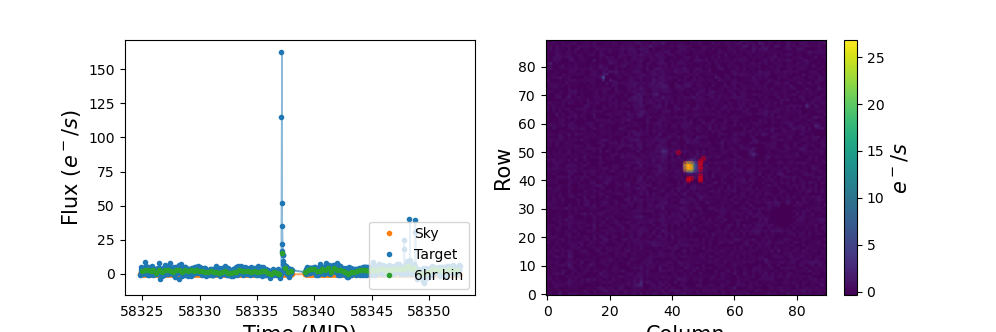

In [4]:
tess = tr.tessreduce(ra = 348.79405058163144, dec = -45.32389674857491,sector=1,plot=False,reduce=True,phot_method='psf')

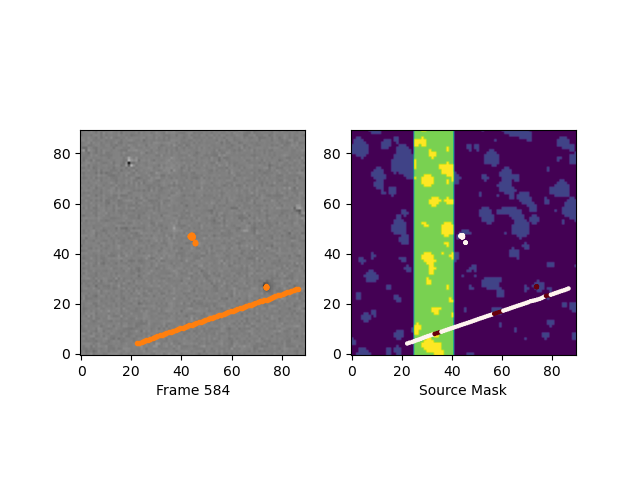

In [148]:
result = source_detect(tess)
plot_results(tess,result)

In [149]:
print(count_detections(result))

{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 4, 74: 9, 113: 1, 194: 1, 206: 185}


,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,...,ycpeak,xpeak,ypeak,flag,frame,psflike,psfdiff,xint,yint,objid
0,2.159095,51,19,42,49,41,48,45.407303,44.461078,2.180473,...,45,45,45,0,586,0.99,0.132918,45,44,73
0,2.206841,30,9,43,48,42,47,45.452944,44.382629,1.574721,...,45,45,45,0,587,0.98,0.214704,45,44,73
0,2.166929,21,4,43,48,42,46,45.406554,44.440601,1.421678,...,45,45,45,0,588,0.96,0.341808,45,44,73
2,2.169486,13,4,44,47,43,46,45.365199,44.347878,0.814400,...,44,45,45,0,589,0.95,0.443030,45,44,73


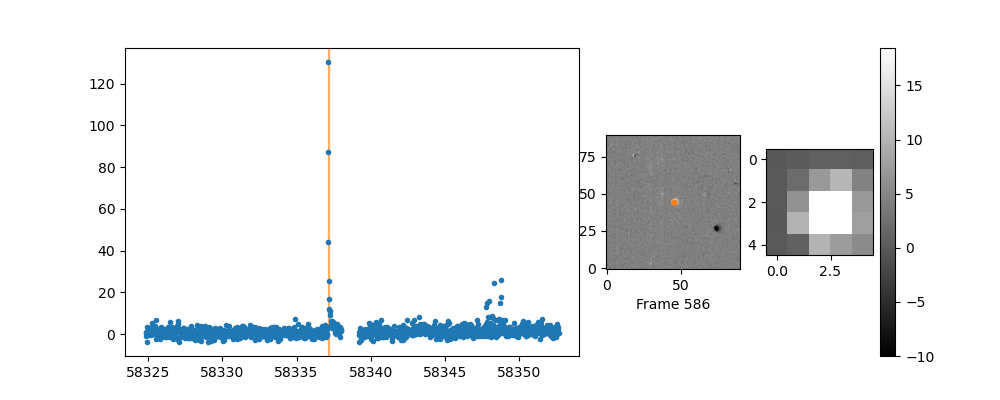

In [176]:
plot_source(tess,result,id=73) # GRB180807A

,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,...,ycpeak,xpeak,ypeak,flag,frame,psflike,psfdiff,xint,yint,objid
1,2.549414,9,4,43,45,46,48,44.017992,47.027957,0.587752,...,47,44,47,0,77,0.87,0.481345,44,47,206
0,2.568511,18,4,42,46,45,49,43.890215,47.024437,1.047914,...,47,44,47,0,104,0.90,0.498057,43,47,206
0,2.635901,26,4,42,46,44,50,44.068232,46.959094,1.279786,...,47,44,47,0,108,0.84,0.495170,44,46,206
1,2.633775,22,5,42,46,45,49,44.051442,47.059071,1.269348,...,47,44,47,0,112,0.90,0.411812,44,47,206
0,2.664880,23,5,42,46,45,49,44.068513,47.184386,1.414296,...,47,44,47,0,113,0.93,0.425644,44,47,206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,2.493197,20,3,42,46,45,49,44.097020,47.091312,1.163244,...,47,44,47,0,644,0.84,0.481821,44,47,206
0,2.371965,16,3,42,46,45,49,44.067479,46.888295,1.070004,...,47,44,47,0,646,0.88,0.430085,44,46,206
0,2.438690,17,4,42,46,45,49,44.009068,46.956647,1.114478,...,47,44,47,0,650,0.91,0.414885,44,46,206
1,2.526491,19,5,42,46,45,49,43.940504,47.019112,1.124462,...,47,44,47,0,908,0.92,0.329914,43,47,206


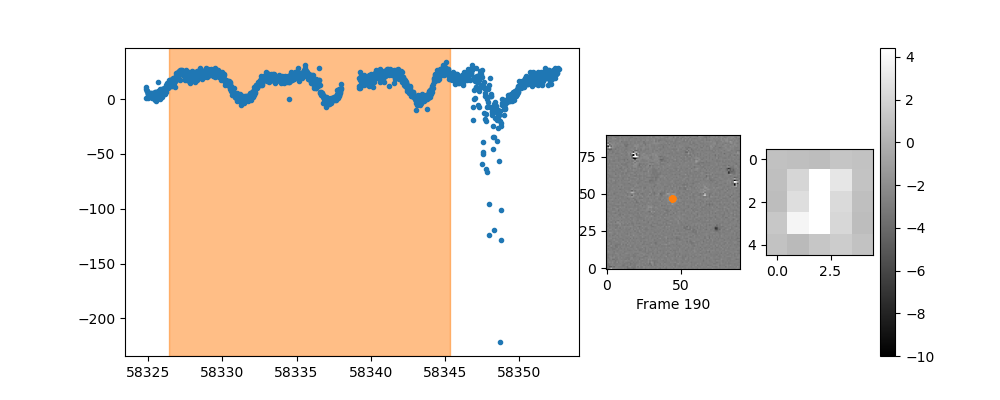

In [177]:
plot_source(tess,result,id=206)   # Clearly Variable Star!

# GRB200412B

getting TPF from TESScut
made reference
7
made source mask
calculating background
background subtracted
Aligning images
!!Re-running for difference image!!
shifting images
7
remade mask
background
Background correlation correction


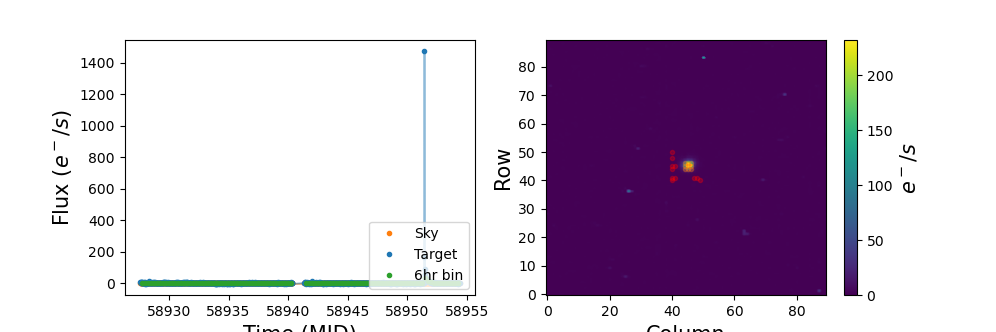

In [155]:
tess2 = tr.tessreduce(ra = 278.313, dec=62.532,sector=23,plot=False,reduce=True,phot_method='psf',calibrate=False)

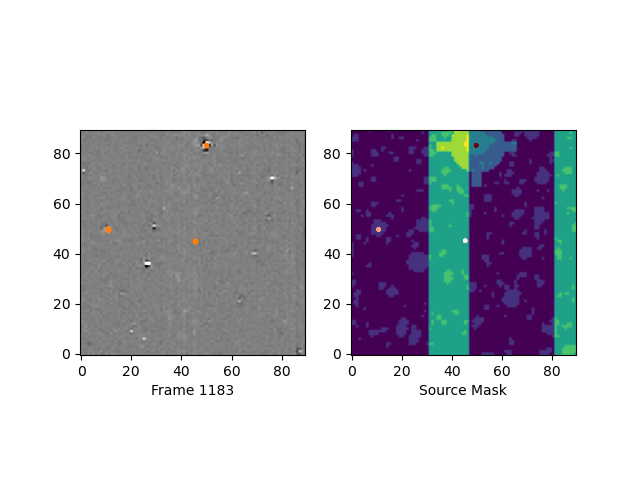

In [156]:
result2 = source_detect(tess2)
plot_results(tess2,result2)

In [157]:
print(count_detections(result2))

{1: 5, 2: 3, 3: 3}


,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,...,ycpeak,xpeak,ypeak,flag,frame,psflike,psfdiff,xint,yint,objid
0,2.477566,70,38,41,50,41,49,45.252500,45.168353,1.753888,...,45,45,45,0,1091,0.99,0.134731,45,45,3
0,2.419468,31,14,42,48,43,48,45.291615,45.162351,1.345923,...,45,45,45,0,1092,0.99,0.132082,45,45,3
0,2.393004,14,7,43,47,44,47,45.229455,45.228331,0.799890,...,45,45,45,0,1095,0.97,0.254224,45,45,3


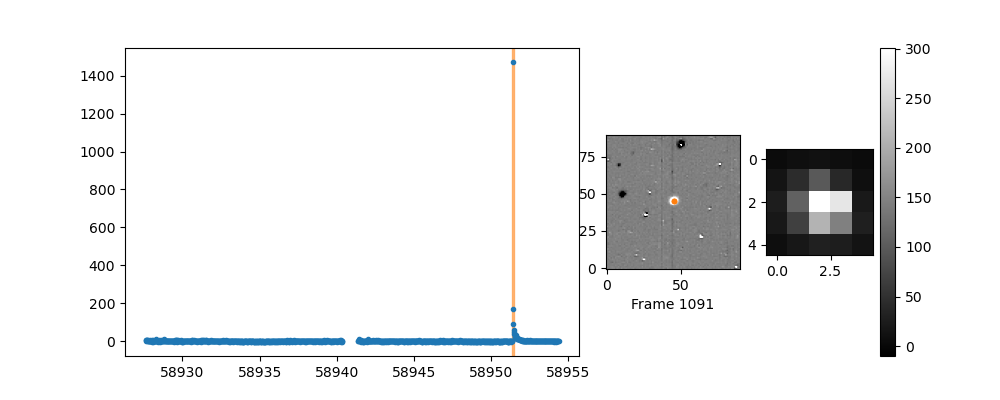

In [174]:
plot_source(tess2,result2,id=3) # GRB200412B

# GRB191016A

getting TPF from TESScut
made reference
7
made source mask
calculating background
background subtracted
Aligning images
!!Re-running for difference image!!
shifting images
7
remade mask
background
Background correlation correction


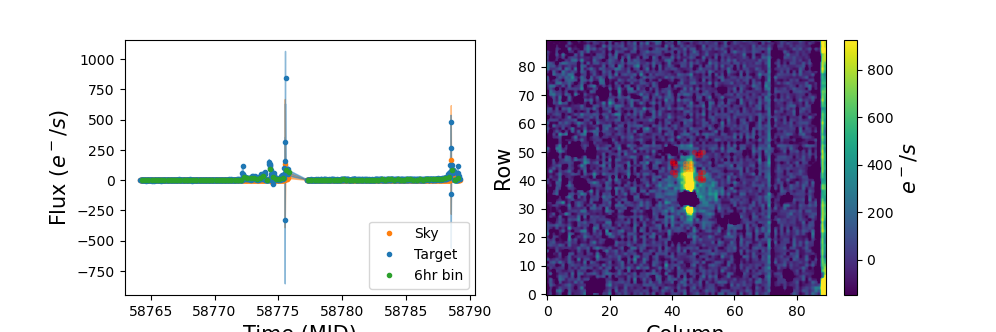

In [161]:
tess3 = tr.tessreduce(ra = 30.2695,dec=24.5099,sector=17,plot=False,reduce=True,phot_method='psf',calibrate=False)

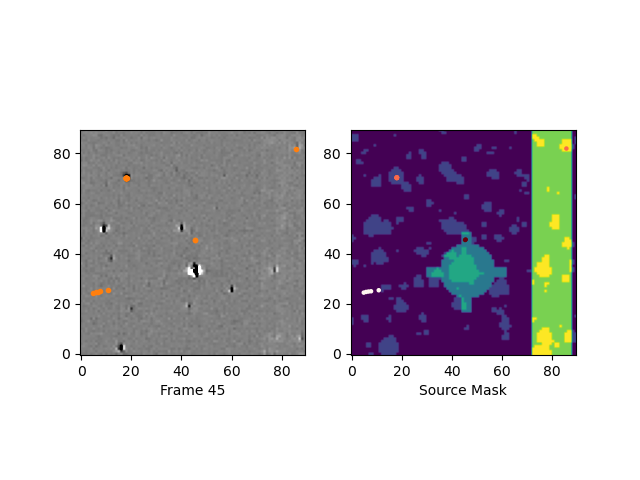

In [163]:
result3 = source_detect(tess3)
plot_results(tess3,result3)

In [164]:
count_detections(result3)

{1: 2, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 12}

,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,...,ycpeak,xpeak,ypeak,flag,frame,psflike,psfdiff,xint,yint,objid
5,5.263401,27,11,43,48,43,49,45.218777,45.462349,1.404029,...,45,45,45,0,382,0.97,0.270258,45,45,1
7,5.976773,24,8,44,48,43,49,45.466221,45.647811,1.343777,...,45,44,48,0,383,0.91,0.410385,45,45,1


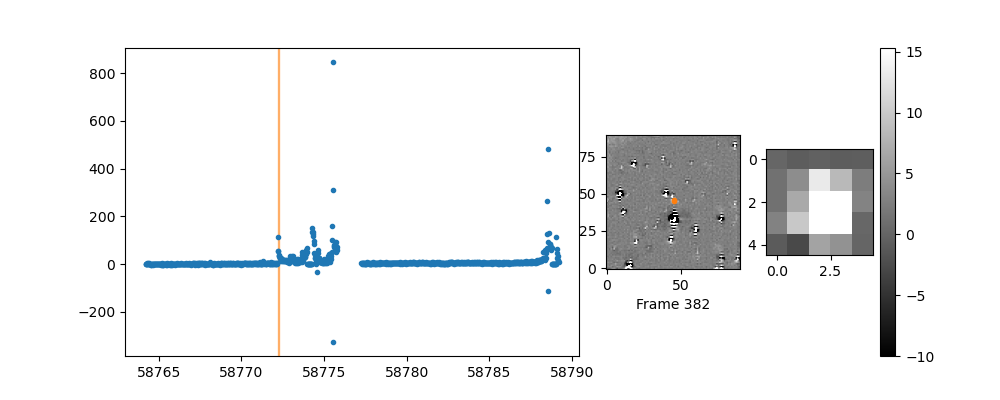

In [175]:
plot_source(tess3,result3,id=1) # GRB191016A